In [1]:
"""
Name: example.ipynb
Authors: Stephan Meighen-Berger
Example for the package
"""

'\nName: example.ipynb\nAuthors: Stephan Meighen-Berger\nExample for the package\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config

In [6]:
# Some example settings
# General
config["general"]["random state seed"] = 1337
# Scenario
config['scenario']['population size'] = 1
config['scenario']['duration'] = 1000
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 1e-1
config['scenario']['injection']['y range'] = [5., 15.]
config['scenario']['light prop'] = {
            "switch": True,
            "x_pos": 5.,
            "y_pos": 10.,
        }
config['scenario']['detector'] = {
    "switch": True,
    "type": "PMTSpec",
    "response": True,
    "acceptance": "Flat",
    "mean detection prob": 0.5
}
# Organisms 
config['organisms']['emission fraction'] = 0.1
config['organisms']['alpha'] = 10.
config['organisms']['photon yield'] = 1e6
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 40.,
    'y_length': 20.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 40.,
    'y_length': 12.,
    "offset": np.array([0., 4.]),
}
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.3,
    "x_pos": 5.,
    "y_pos": 10.,
}
# Water
config['water']['model']['name'] = 'custom' # 'potential cylinder'
config['water']['model']['directory'] = "../data/current/cyclic/"
config['water']['model']['time step'] = 50
config['advanced']['starting step'] = 575

In [7]:
# Creating a fourth_day object
fd = Fourth_Day()

In [8]:
# Launching solver
fd.sim()

In [9]:
# from scipy.stats import gamma
# test_array=np.full((24,),10)
# gamma.pdf(test_array,a=3)

In [10]:
fd.statistics[-1]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,regeneration,pulse mean,pulse sd,is_emitting,emission_duration,encounter photons,shear photons,photons
0,Lampea sp.,40.040106,4.594026,0.0,0.0,0.000509,0.8469,False,8.093081,0.1,0.0001,5.0,4.0,False,-93.0,0.0,0.0,0.0
1,Lampea sp.,40.039724,13.744321,0.0,0.0,0.001007,0.7456,False,6.615986,0.1,0.0001,5.0,4.0,False,-5.0,0.0,0.0,0.0
2,Lampea sp.,40.008577,14.476485,0.0,0.0,0.000421,0.6736,False,6.888607,0.1,0.0001,5.0,4.0,False,-28.0,0.0,0.0,0.0
3,Bathyctena chuni (Moser),40.015767,6.159742,0.0,0.0,0.001367,0.8530,False,4.733136,0.1,0.0001,2.0,1.0,False,-59.0,0.0,0.0,0.0
4,Bathyctena chuni (Moser),40.039070,5.574710,0.0,0.0,0.001135,0.6737,False,15.184639,0.1,0.0001,2.0,1.0,True,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,Euphysora valdiviae Vanhoeffen,0.000000,9.307311,0.0,0.0,0.001227,1.0000,True,9.693304,0.1,0.0001,20.0,15.0,False,0.0,0.0,0.0,0.0
2497,Bathyctena chuni (Moser),0.000000,6.185203,0.0,0.0,0.001232,1.0000,True,23.550336,0.1,0.0001,2.0,1.0,False,0.0,0.0,0.0,0.0
2498,Lampea sp.,0.000000,14.127277,0.0,0.0,0.001116,1.0000,True,5.446102,0.1,0.0001,5.0,4.0,False,0.0,0.0,0.0,0.0
2499,Bathyctena chuni (Moser),0.000000,13.654502,0.0,0.0,0.001123,1.0000,True,10.718150,0.1,0.0001,2.0,1.0,False,0.0,0.0,0.0,0.0


In [11]:
# Random noise
noise = np.abs(np.random.normal(2e2, 1e2, len(fd.t)))

In [12]:
# Plotting standards
std_size = 10.
fontsize = 20.
lw=1.5
h_length=1.5

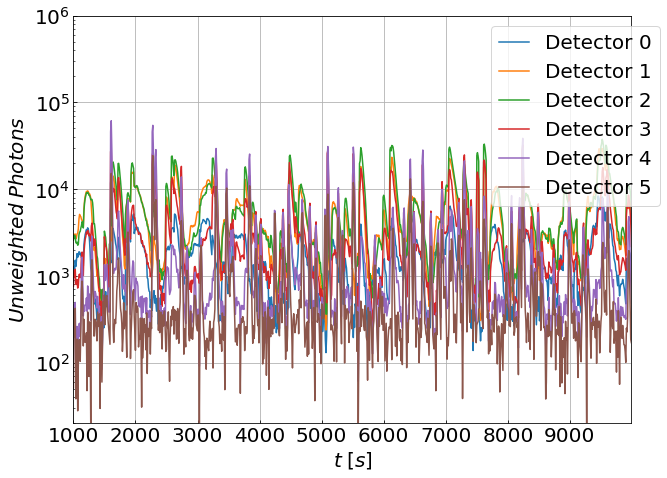

In [13]:
# Energy distributions
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
for detector in fd.measured.keys():
    ax1.plot(fd.t / 5.,
             fd.measured[detector].values + noise,
             lw=lw, label=detector)
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$t\;[s]$', fontsize=fontsize)
ax1.set_ylabel(r'$Unweighted\;Photons$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.9, +1.),
                  ncol=1, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=True)
ax1.set_ylim(2e1,1e6)
ax1.set_xlim(1e3, max(fd.t / 5.))
plt.show()

In [14]:
figure.savefig(PICS + "MC_Example.png",
               bbox_inches='tight')